# Laboratorium 6 - rekomendacje oparte na grafach wiedzy

## Przygotowanie

 * pobierz i wypakuj dataset: https://www.aicrowd.com/challenges/spotify-million-playlist-dataset-challenge
   * na potrzeby drugiej części laboratorium (czyli testowego treningu), na Teamsach macie dostępny podzbiór danych, `a_few_playlists_dataset` - nie wystarczy on jednak do wykonania trzeciej części (i tym samym do oddania laboratorium)
 * [opcjonalnie] Utwórz wirtualne środowisko
 `python3 -m venv ./recsyslab6`
 * zainstaluj potrzebne biblioteki:
 `pip install numpy pandas pykeen tqdm seaborn`

## Część 1. - przygotowanie danych

In [19]:
import json
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import random

from pykeen.models import TransR, RESCAL, PairRE
from pykeen.pipeline import pipeline
from pykeen.predict import predict_target
from pykeen.triples import TriplesFactory

In [4]:
# jesli uzywasz datasetu pobranego z Teamsow, uzyj tej komorki zamiast powyzszej
# UWAGA - do oddania laboratorium konieczne jest uzycie oficjalnego datasetu Spotify
PATH = 'a_few_playlists_dataset'
SAMPLING_RATIO = 0.01
with open(f'{PATH}/filenames.txt') as fn:
    FILENAMES = fn.read().split('\n')

In [5]:
# funkcje do parsowania playlist
def get_id(uri):
    return uri.split(':')[-1]

def parse_playlist(playlist):
    name = playlist['name']
    tracks = [get_id(t['track_uri']) for t in playlist['tracks']]
    tracks_to_artists = {(get_id(t['track_uri']), get_id(t['artist_uri'])) for t in playlist['tracks']}
    tracks_to_albums = {(get_id(t['track_uri']), get_id(t['album_uri'])) for t in playlist['tracks']}
    albums_to_artists = {(get_id(t['album_uri']), get_id(t['artist_uri'])) for t in playlist['tracks']}
    return name, tracks, tracks_to_artists, tracks_to_albums, albums_to_artists

In [6]:
# parsing
playlists = []
tracks = set()
tracks_to_artists = set()
tracks_to_albums = set()
albums_to_artists = set()

for filename in tqdm(FILENAMES):
    with open(f'{PATH}/{filename}') as mpd_chunk:
        for playlist in json.loads(mpd_chunk.read())['playlists']:
            a, b, c, d, e = parse_playlist(playlist)
            playlists.append(b)
            tracks.update(set(b))
            tracks_to_artists.update(c)
            tracks_to_albums.update(d)
            albums_to_artists.update(e)

print(f'Got: {len(playlists):,} playlists; {len(tracks):,} tracks; {len({x[1] for x in tracks_to_albums}):,} albums; {len({x[1] for x in tracks_to_artists}):,} artists')

100%|██████████| 10/10 [00:06<00:00,  1.58it/s]

Got: 10,000 playlists; 175,992 tracks; 84,206 albums; 36,844 artists


In [7]:
# w zbiorze testowym chcemy tylko te playlisty, ktorych wszystkie piosenki wystapia takze choc raz w zbiorze treningowym
tracks_counter = {}
for p in tqdm(playlists):
    for t in p:
        if t in tracks_counter:
            tracks_counter[t] += 1
        else:
            tracks_counter[t] = 1

playlists_with_only_non_unique_tracks = []
for i in tqdm(range(len((playlists)))):
    p = playlists[i]
    if all([tracks_counter[t] > 1 for t in p]):
        playlists_with_only_non_unique_tracks.append(i)

# zbior testowy to 1/10 wszystkich playlist - czyli 100k, jesli nie używamy samplingu
test_playlist_ids = random.sample(playlists_with_only_non_unique_tracks, int(SAMPLING_RATIO*100_000))
# zbior treningowy to cala reszta playlist - jest ich duzo, wiec sprobujmy to zrobic wydajnie
test_ids_sorted = sorted(test_playlist_ids)
test_i = 0
train_playlist_ids = []
i = 0
while i < len(playlists):
    if test_i < len(test_ids_sorted) and test_ids_sorted[test_i] == i:
        test_i += 1
    else:
        train_playlist_ids.append(i)
    i += 1

train_playlists = [playlists[i] for i in train_playlist_ids]
test_playlists = [playlists[i] for i in test_playlist_ids]

print(f'train dataset: {len(train_playlists):,}; test dataset: {len(test_playlists):,}')

100%|██████████| 10000/10000 [00:00<00:00, 33297.75it/s]

train dataset: 9,000; test dataset: 1,000


## Część 2. - budowa i ewaluacja modelu

### Relacje istniejące w naszym datasecie:
![poglądowy obrazek relacji w datasecie](relations.svg)

In [8]:
# budowanie zbioru relacji
# mozesz usunac czesc wpisow z listy `relations`
relations = ['follows', 'authored_by', 'in_album', 'authored']
triples = []

# relacje piosenka -> autor
if 'authored_by' in relations:
    for track, artist in tqdm(tracks_to_artists):
        triples.append((track, 'authored_by', artist))

# relacje piosenka -> artysta
if 'in_album' in relations:
    for track, album in tqdm(tracks_to_albums):
        triples.append((track, 'in_album', album))

# relacje artysta -> album
if 'authored' in relations:
    for album, artist in tqdm(albums_to_artists):
        triples.append((artist, 'authored', album))

# relacje piosenka -> piosenka
if 'follows' in relations:
    for playlist in tqdm(train_playlists):
        for i in range(len(playlist)-1):
            triples.append((playlist[i], 'follows', playlist[i+1]))

num_entities = len(triples)
num_relations = len(relations)

print(f'Got {num_relations} relations with total of {num_entities:,} entries')

100%|██████████| 9000/9000 [00:00<00:00, 33386.17it/s]

Got 4 relations with total of 1,064,566 entries


In [9]:
# trening
tf = TriplesFactory.from_labeled_triples(np.array(triples))
# ta dysproporcja jest po to, by szybko uzyskac jakikolwiek wynik
#   - dla uzyskania sensownych wynikow warto zmienic split na np. standardowe 80-10-10
training, testing, validation = tf.split([.9998, .0001, .0001])

pipeline_result = pipeline(
    training=training,
    testing=testing,
    validation=validation,
    model=TransR, # to najszybszy i najprostszy, ale i najgorszy model; pomysl o uzyciu TransH, TransR, RESCAL albo dowolnego innego
    epochs=30, # to zdecydowanie za malo - 1 wystarczy do jakichkolwiek wynikow, 5 do dosc slabych, blizej 20 do sensownych
    training_kwargs={"batch_size":2**14},
    evaluation_kwargs={"batch_size":16},
    device="cuda"
)

using automatically assigned random_state=2164295452
No random seed is specified. Setting to 3747793699.


Training epochs on cuda:0:   0%|          | 0/20 [00:00<?, ?epoch/s]

Training batches on cuda:0:   0%|          | 0/62 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/62 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/62 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/62 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/62 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/62 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/62 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/62 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/62 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/62 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/62 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/62 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/62 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/62 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/62 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/62 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/62 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/62 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/62 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/62 [00:00<?, ?batch/s]

Evaluating on cuda:0:   0%|          | 0.00/101 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 12.09s seconds


<Axes: title={'center': 'Losses Plot'}, xlabel='Epoch', ylabel='marginranking Loss'>

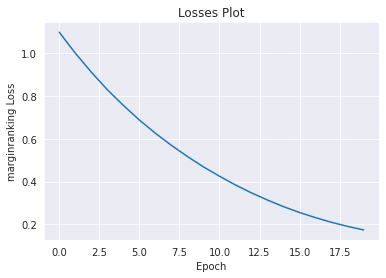

In [10]:
# zgrubne oszacowanie jakosci wytrenowanego modelu
pipeline_result.plot_losses()

In [11]:
model = pipeline_result.model

In [12]:
# funkcja zwracajaca predykcje z modelu
from typing import List
import torch
def predict_next_tracks(model, track_id: str, k: int) -> List[str]:
    next_tracks = []
    for _ in range(k):
        batch = torch.tensor([(tf.entity_to_id[track_id], tf.relation_to_id['follows'])])
        _, indicies = torch.topk(model.predict_t(batch), k=2)
        next_track = tf.entity_id_to_label[indicies[0][1].item()]
        next_tracks.append(next_track)
        track_id = next_track

    return next_tracks


predict_next_tracks(model, train_playlists[42][2], 10)

['0lMwsRjgzmEhiv3anRRl7q',
 '1mKXFLRA179hdOWQBwUk9e',
 '0lMwsRjgzmEhiv3anRRl7q',
 '1mKXFLRA179hdOWQBwUk9e',
 '0lMwsRjgzmEhiv3anRRl7q',
 '1mKXFLRA179hdOWQBwUk9e',
 '0lMwsRjgzmEhiv3anRRl7q',
 '1mKXFLRA179hdOWQBwUk9e',
 '0lMwsRjgzmEhiv3anRRl7q',
 '1mKXFLRA179hdOWQBwUk9e']

In [13]:
# metryki do porownania rekomenderow - precision@k i recall@k
def precision(prediction: List[str], actual_tracks: List[str]) -> float:
    count = 0

    for predicated_track in prediction:
        if predicated_track in actual_tracks:
            count += 1
    
    return count / len(prediction)

def recall(prediction: List[str], actual_tracks: List[str]) -> float:
    count = 0

    for predicated_track in prediction:
        if predicated_track in actual_tracks:
            count += 1
    
    return count / len(actual_tracks)

912
0
100
200
300
400
500
600
700
800
900


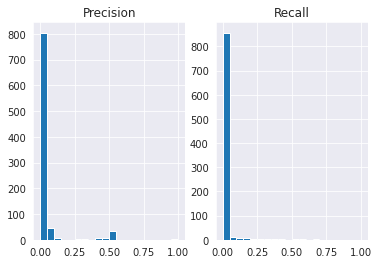

In [15]:
# ocena wynikow

# odsiewamy playlisty zbyt krotkie, by dac sensowne wyniki
long_enough_test_playlists = [p for p in test_playlists if len(p) >= 10]
print(len(long_enough_test_playlists))
# z kazdej playlisty, elementy od 0 do `cutoff_idx` wlacznie sa dane, na ich podstawie robimy predykcje
# elementy od cutoff_idx+1 do konca powinnismy umiec przewidziec
cutoff_idx = 4
# ile elementow ma przewidziec nasz model
k = 20
precisions: List[float] = []
recalls: List[float] = []
for idx, playlist in enumerate(long_enough_test_playlists):
    if idx % 100 ==0: print(idx)
    prediction = predict_next_tracks(model, playlist[cutoff_idx], k)
    precisions.append(precision(prediction, playlist))
    recalls.append(recall(prediction, playlist))

# histogram z wynikami
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist(precisions, bins=20)
ax1.set_title('Precision')
ax2.hist(recalls, bins=20)
ax2.set_title('Recall')
plt.show()

## Część 3. - porównanie różnych metod rekomendacji

W części 2. zbudowaliśmy zbiór trójek relacji, wytrenowaliśmy jeden model, zaimplementowaliśmy (prostą) metodę generującą rekomendacje na podstawie predykcji modelu i w końcu zaimplementowaliśmy dwie metryki do porównania jakości tych rekomendacji.

W części 3. Twoim zadaniem jest przetestować trzy różne podejścia do jednego z kroków:
1. Porównaj trzy różne modele spośród dostępnych w bibliotece PyKeen: https://pykeen.readthedocs.io/en/stable/reference/models.html#classes
   * jeden model translacyjny (np. TransE, TransH, TransR)
   * jeden model faktoryzacyjny (np. RESCAL)
   * jeden dowolny model niewybrany w poprzednich punktach
2. Porównaj trzy metody budowania grafu wiedzy:
   * graf zawierający relacje wszystkich czterech typów
   * graf zawierający tylko relacje typu `follows` (czyli między kolejnymi utworami w playliście)
   * graf zawierający relacje wybranych przez Ciebie dwóch lub trzech typów (czyli krok pośredni między powyższymi punktami)
3. Porównaj trzy metody generowania rekomendacji na podstawie elementów zwróconych przez `predict_target()` (ta metoda zwraca m. in. score'y każdego z proponowanych elementów, co może okazać się pomocne):
   * metoda opierająca się tylko na predykcji dla ostatniego znanego elementu w playliście
   * dwie wymyślone przez Ciebie, bardziej zaawansowane metody
  
Niezależnie od tego, który z trzech powyższych scenariuszy wybierzesz - porównaj trzy wybrane przez Ciebie metody na podstawie histogramów metryk `precision@k` i `recall@k`.

INFO:pykeen.pipeline.api:Using device: cuda


Training RESCAL


Training epochs on cuda:0:   0%|          | 0/30 [00:00<?, ?epoch/s]

Training batches on cuda:0:   0%|          | 0/62 [00:00<?, ?batch/s]

KeyboardInterrupt: 

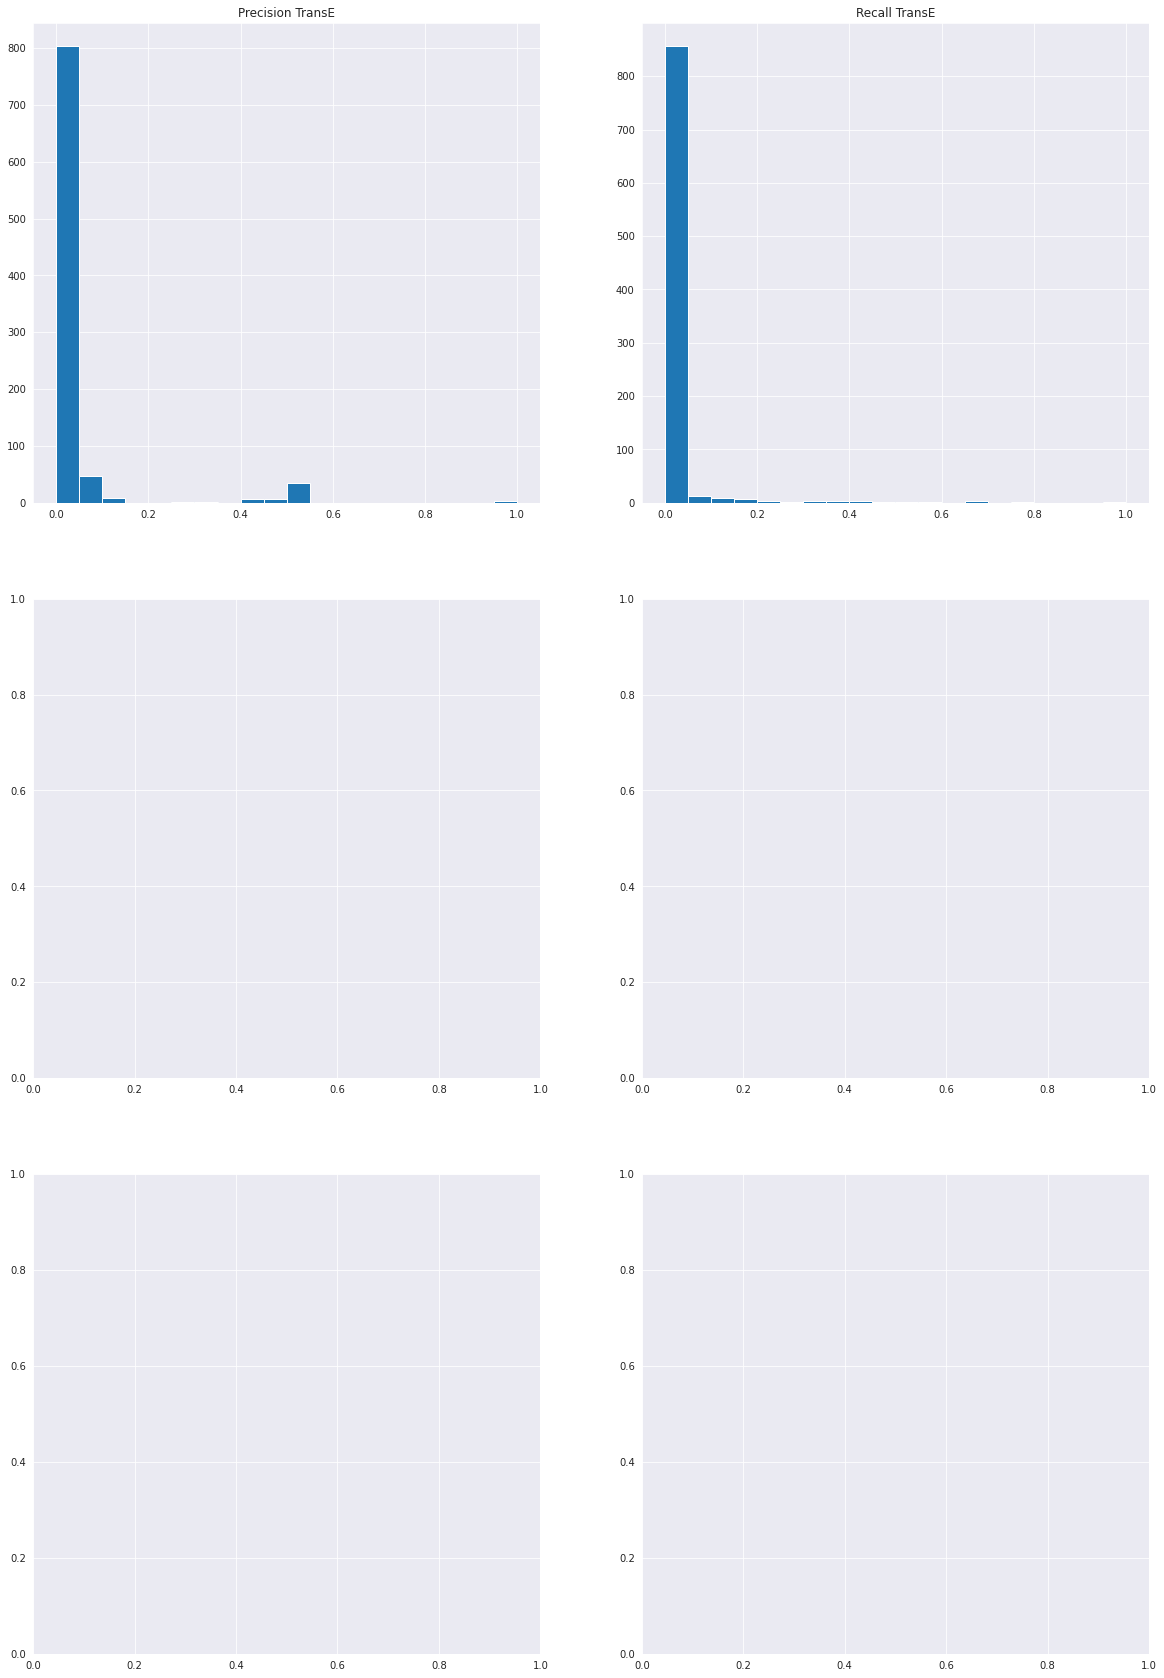

In [17]:
fig, axs = plt.subplots(3, 2)
fig.set_size_inches(20, 30)

pipeline_transE = pipeline_result

axs[0][0].hist(precisions, bins=20)
axs[0][0].set_title('Precision TransE')
axs[0][1].hist(recalls, bins=20)
axs[0][1].set_title('Recall TransE')

print("Training RESCAL")

pipeline_rescal = pipeline(
    training=training,
    testing=testing,
    validation=validation,
    model=RESCAL,
    epochs=30,
    training_kwargs={"batch_size":2**14},
    device="cuda",
)

model = pipeline_rescal.model

print("Evaluting RESCAL")

precisions: List[float] = []
recalls: List[float] = []
for idx, playlist in enumerate(long_enough_test_playlists):
    if idx % 100 ==0: print(idx)
    prediction = predict_next_tracks(model, playlist[cutoff_idx], k)
    precisions.append(precision(prediction, playlist))
    recalls.append(recall(prediction, playlist))

axs[1][0].hist(precisions, bins=20)
axs[1][0].set_title('Precision RESCAL')
axs[1][1].hist(recalls, bins=20)
axs[1][1].set_title('Recall RESCAL')

print("Training PairRE")

pipeline_pairRE = pipeline(
    training=training,
    testing=testing,
    validation=validation,
    model=PairRE, 
    epochs=30,
    training_kwargs={"batch_size":2**14},
    device="cuda"
)

model = pipeline_pairRE.model

print("Evaluting PairRE")

precisions: List[float] = []
recalls: List[float] = []
for idx, playlist in enumerate(long_enough_test_playlists):
    if idx % 100 ==0: print(idx)
    prediction = predict_next_tracks(model, playlist[cutoff_idx], k)
    precisions.append(precision(prediction, playlist))
    recalls.append(recall(prediction, playlist))

axs[2][0].hist(precisions, bins=20)
axs[2][0].set_title('Precision PairRE')
axs[2][1].hist(recalls, bins=20)
axs[2][1].set_title('Recall PairRE')

plt.show()

In [18]:
!git add .
!git commit -m "Lab 6 remote push"
!git push -u origin main

[main 74f059e] Test push
 1 file changed, 7 insertions(+)
Enumerating objects: 27, done.
Counting objects: 100% (27/27), done.
Delta compression using up to 8 threads
Compressing objects: 100% (27/27), done.
Writing objects: 100% (27/27), 1.89 MiB | 3.00 MiB/s, done.
Total 27 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3), done.
To github.com:pweglik/rekomendacyjne.git
 * [new branch]      main -> main
Branch 'main' set up to track remote branch 'main' from 'origin'.
